# Word2Vec 
Its an embedding method that encodes words into vectors

In [649]:
text =''' Physics is the natural science of matter, involving the study of matter,[a] its fundamental constituents, its motion and behavior through space and time, and the related entities of energy and force.[2] Physics is one of the most fundamental scientific disciplines, with its main goal being to understand how the universe behaves.[b][3][4][5] A scientist who specializes in the field of physics is called a physicist.'''

## Tokenization

In [650]:
import re

def tokenize(text) -> list:
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

In [651]:
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /home/amadej/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [653]:
tokenized = tokenize(text)
unique_tokens = list(set(tokenized))
stop_words = set(stopwords.words('english'))
filtered_tokens = [token for token in unique_tokens if token.lower() not in stop_words]
# Lemmatization
lemmatizer = WordNetLemmatizer()
tokens = list(set([lemmatizer.lemmatize(token) for token in filtered_tokens]))

## Mapping
Now we need to create 2 dictionaries: One for token to index and one from index to token 

In [654]:
def mapping(tokens)->(dict,dict):
    '''
    returns a lookup table
    '''
    words_to_ids = dict()
    ids_to_words = dict()

    for key,value in enumerate(tokens):
        words_to_ids[key] = value
        ids_to_words[value] = key
    return (words_to_ids,ids_to_words)

In [655]:
ids_to_words,words_to_ids = mapping(tokens)

## Dataset generation
Now we generate the actual training data. 
1. We have to encode tokens into vectors using one-hot encoding and generate input/output dataset.
2. We loop through each token in the sentence. In each loop, we look at words to the left and right of the input word. This is how we get context.
How far do we look? Window size takes care of that.

In [656]:
def one_hot_encode(id, vocab_size) -> list: return [1 if i == id else 0 for i in range(vocab_size)]

In [657]:
import numpy as np
from tqdm import tqdm

np.random.seed(42) # we do this so we can repeat the same results even with randomization
WINDOW_SIZE = 2

In [658]:
def generate_training_data(tokens:list, word_to_id_dict:dict, window_size:int) -> tuple:
    '''
    generates X and y data for training
    '''
    X = []
    y = []
    vocab_size = len(word_to_id_dict)
    for i in tqdm(range(len(tokens))): #for each token
        for j in range(max(0,i-window_size) ,min(len(tokens), i+window_size+1)): # we check the window size of context before and after it
            if i != j:# and tokens[i] != tokens[j]: # <- no information gained if we embed the same word
                X.append(one_hot_encode(word_to_id_dict[tokens[i]], vocab_size))
                y.append(one_hot_encode(word_to_id_dict[tokens[j]],vocab_size))                
    
    return np.array(X), np.array(y)

In [659]:
X,y = generate_training_data(tokens, words_to_ids,WINDOW_SIZE)
X.shape, y.shape

100%|████████████████████████████████████████| 30/30 [00:00<00:00, 17454.45it/s]


((114, 30), (114, 30))

## The Embedding Model
We take our input matrix, multiply it by the weight matrix and out we get the embedding matrix.

The weight matrix helps to represent our words as dense vectors and not sparsed out matrix with one hot encoded vectors in it.

The output of the embedding model is going to be a probability vector because it will be passes through softmax layer. The final output can be considered as context predictions, i.e. which words are likely to be in the window vicinity of the input word.
### Process
1. Embeddings are rows of the first weight matrix W1 -> we adjust them with backpropagation after feedforwarding, along with W2 weight matrix
2. Z is the matrix that contains the prediction probability vectors

In [660]:
def init_network(vocab_size, n_embedding):
    model = {
        "W1": np.random.randn(vocab_size, n_embedding),
        "W2": np.random.randn(n_embedding, vocab_size)
    }
    return model

In [661]:
EMBEDDING_DIMENSIONS = 10 # each token will be represented as EMBEDDING_DIMENSIONS-dimensional vector (usually 300)
model = init_network(len(words_to_ids),EMBEDDING_DIMENSIONS)

### FeedForwarding 

In [662]:
def softmax(X):
    res = []
    for i in X:
        exp = np.exp(i)
        res.append(exp/np.sum(exp))
    return np.array(res)
    
def forward(model:dict,X, return_cache=True):
    '''
    we calculate A1 = X*W1
                 A2 = A1*W2
                 Z  = softmax(A2)
    '''
    cache = {} # we need cache in case of backpropagation 
    cache['A1'] = X@model['W1']
    cache['A2'] = cache['A1']@model['W2']
    cache['Z'] = softmax(cache['A2'])
    if not return_cache:
        return cache['Z']
    return cache

In [663]:
s = X@model['W1']
r = s@model['W2']
e = softmax(r)
s.shape, r.shape,e.shape

((114, 10), (114, 30), (114, 30))

### Backpropagation

In [664]:
def cross_entropy(z,y):
    return -np.sum(np.log(z)*y)

def backward(model,X,y,alpha):
    cache = forward(model,X)
    da2 = cache["Z"] - y
    dw2 = cache["A1"].T @ da2
    da1 = da2 @ model["W2"].T
    dw1 = X.T @ da1
    assert(dw2.shape == model["W2"].shape)
    assert(dw1.shape == model["W1"].shape)
    model["W1"] -= alpha * dw1
    model["W2"] -= alpha * dw2
    return cross_entropy(cache["Z"],y) # final return of the backpropagation process is cross entropy to keep a log
    

## Model testing

In [665]:
EPOCHS = 500
LEARNING_RATE = 0.01
errors = []
model = init_network(len(words_to_ids),EMBEDDING_DIMENSIONS)
for _ in tqdm(range(EPOCHS)):
    current_error = backward(model,X,y,LEARNING_RATE)
    errors.append(current_error)

100%|████████████████████████████████████████| 500/500 [00:00<00:00, 780.72it/s]


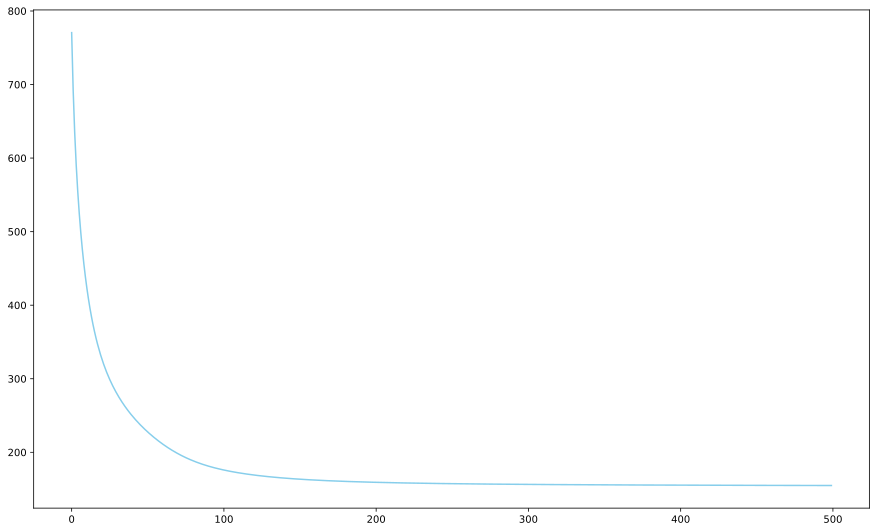

In [666]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,9))
plt.plot(range(len(errors)), errors, color="skyblue")
plt.show()

## Testing the model

In [672]:
inference_vector = one_hot_encode(words_to_ids["universe"], len(words_to_ids))

In [673]:
prediction = forward(model,[inference_vector], return_cache=False)[0]

for word in (ids_to_words[id] for id in np.argsort(prediction)[::-1]):   
    print(word)

entity
physicist
universe
physic
behaves
related
constituent
field
science
called
fundamental
one
b
space
study
time
matter
involving
scientific
specializes
goal
motion
behavior
main
energy
natural
scientist
understand
force
discipline


### Cosine distance calculation
We can calculate cosine similarity and distance between different token vectors in embedding matrix and make a heatmap of similar words?

In [674]:
W1 = model['W1'] # W1 shape: (num_tokens, embedding_dimension)

# first we normalize the embeddings
norms = np.linalg.norm(W1, axis=1, keepdims=True)
normalized_W1 = W1 / norms

In [675]:
# Step 2: Compute cosine similarity
cosine_similarity_matrix = np.dot(normalized_W1, normalized_W1.T)
cosine_distance_matrix = 1 - cosine_similarity_matrix

In [676]:
import seaborn as sns

In [680]:
mask = np.triu(np.ones_like(cosine_distance_matrix, dtype=bool))

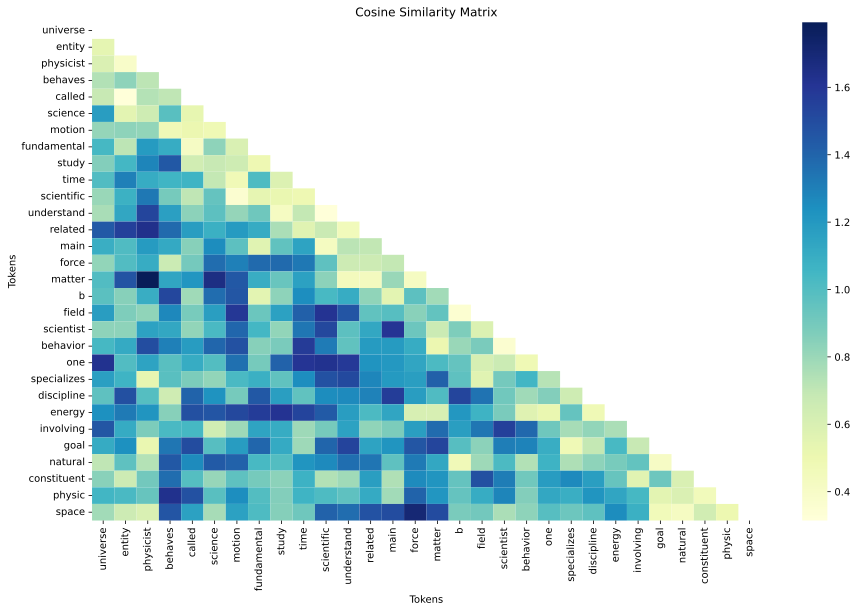

In [681]:
fig = plt.figure(figsize = (15,9))
dataplot = sns.heatmap(cosine_distance_matrix.T,xticklabels=tokens,mask=mask,yticklabels=tokens, cmap="YlGnBu")   
plt.xlabel('Tokens')
plt.ylabel('Tokens')
plt.title('Cosine Similarity Matrix')
plt.show()